In [2]:
import chess
import chess.engine
import random
import numpy as np

In [3]:
def random_board(max_depth = 200):
    board = chess.Board()
    depth = random.randrange(0, max_depth)
    
    for _ in range(depth):
        random_move = random.choice(list(board.legal_moves))
        board.push(random_move)
        if board.is_game_over():
            break
    return board

In [4]:
def stockfish(board, depth = 0):
    with chess.engine.SimpleEngine.popen_uci("../stockfish/stockfish-ubuntu-x86-64-avx2") as sf:
        result = sf.analyse(board, chess.engine.Limit(depth = depth))
        score = result["score"].white().score()
        return score

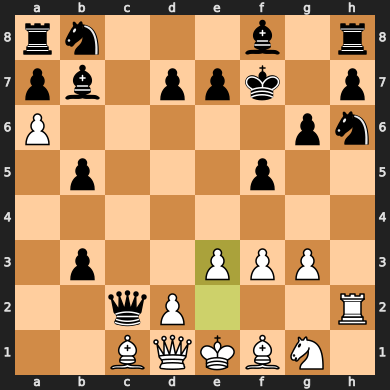

In [5]:
board = random_board()
board

In [6]:
print(stockfish(board, 10))

-909


In [7]:
square_index = {
    'a' : 0,
    'b' : 1,
    'c' : 2,
    'd' : 3,
    'e' : 4,
    'f' : 5,
    'g' : 6,
    'h' : 7
}

def square_to_index(square):
    letter = chess.square_name(square)
    return 8 - int(letter[1]), square_index[letter[0]]

def split_dims(board):
    board3d = np.zeros((14, 8, 8), np.int8)
    
    for piece in chess.PIECE_TYPES:
        for square in board.pieces(piece, chess.WHITE):
            idx = np.unravel_index(square, (8, 8))
            board3d[piece - 1][7 - idx[0]][idx[1]] = 1
        for square in board.pieces(piece, chess.BLACK):
            idx = np.unravel_index(square, (8, 8))
            board3d[piece + 5][7 - idx[0]][idx[1]] = 1
    
    aux = board.turn 
    board.turn = chess.WHITE
    for move in board.legal_moves:
        i, j = square_to_index(move.to_square)
        board3d[13][i][j] = 1
    board.turn = aux
    
    return board3d

In [8]:
split_dims(board)

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

In [9]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers

In [10]:
def build_model(conv_size, conv_depth):
    board3d = layers.Input(shape = (14, 8, 8))
    
    x = board3d
    for _ in range(conv_depth):
        x = layers.Conv2D(filters = conv_size, kernel_size = 3,
                          padding = 'same', activation = 'relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation = 'relu')(x)
    x = layers.Dense(1, activation = 'sigmoid')(x)
    
    return models.Model(inputs = board3d, outputs = x)

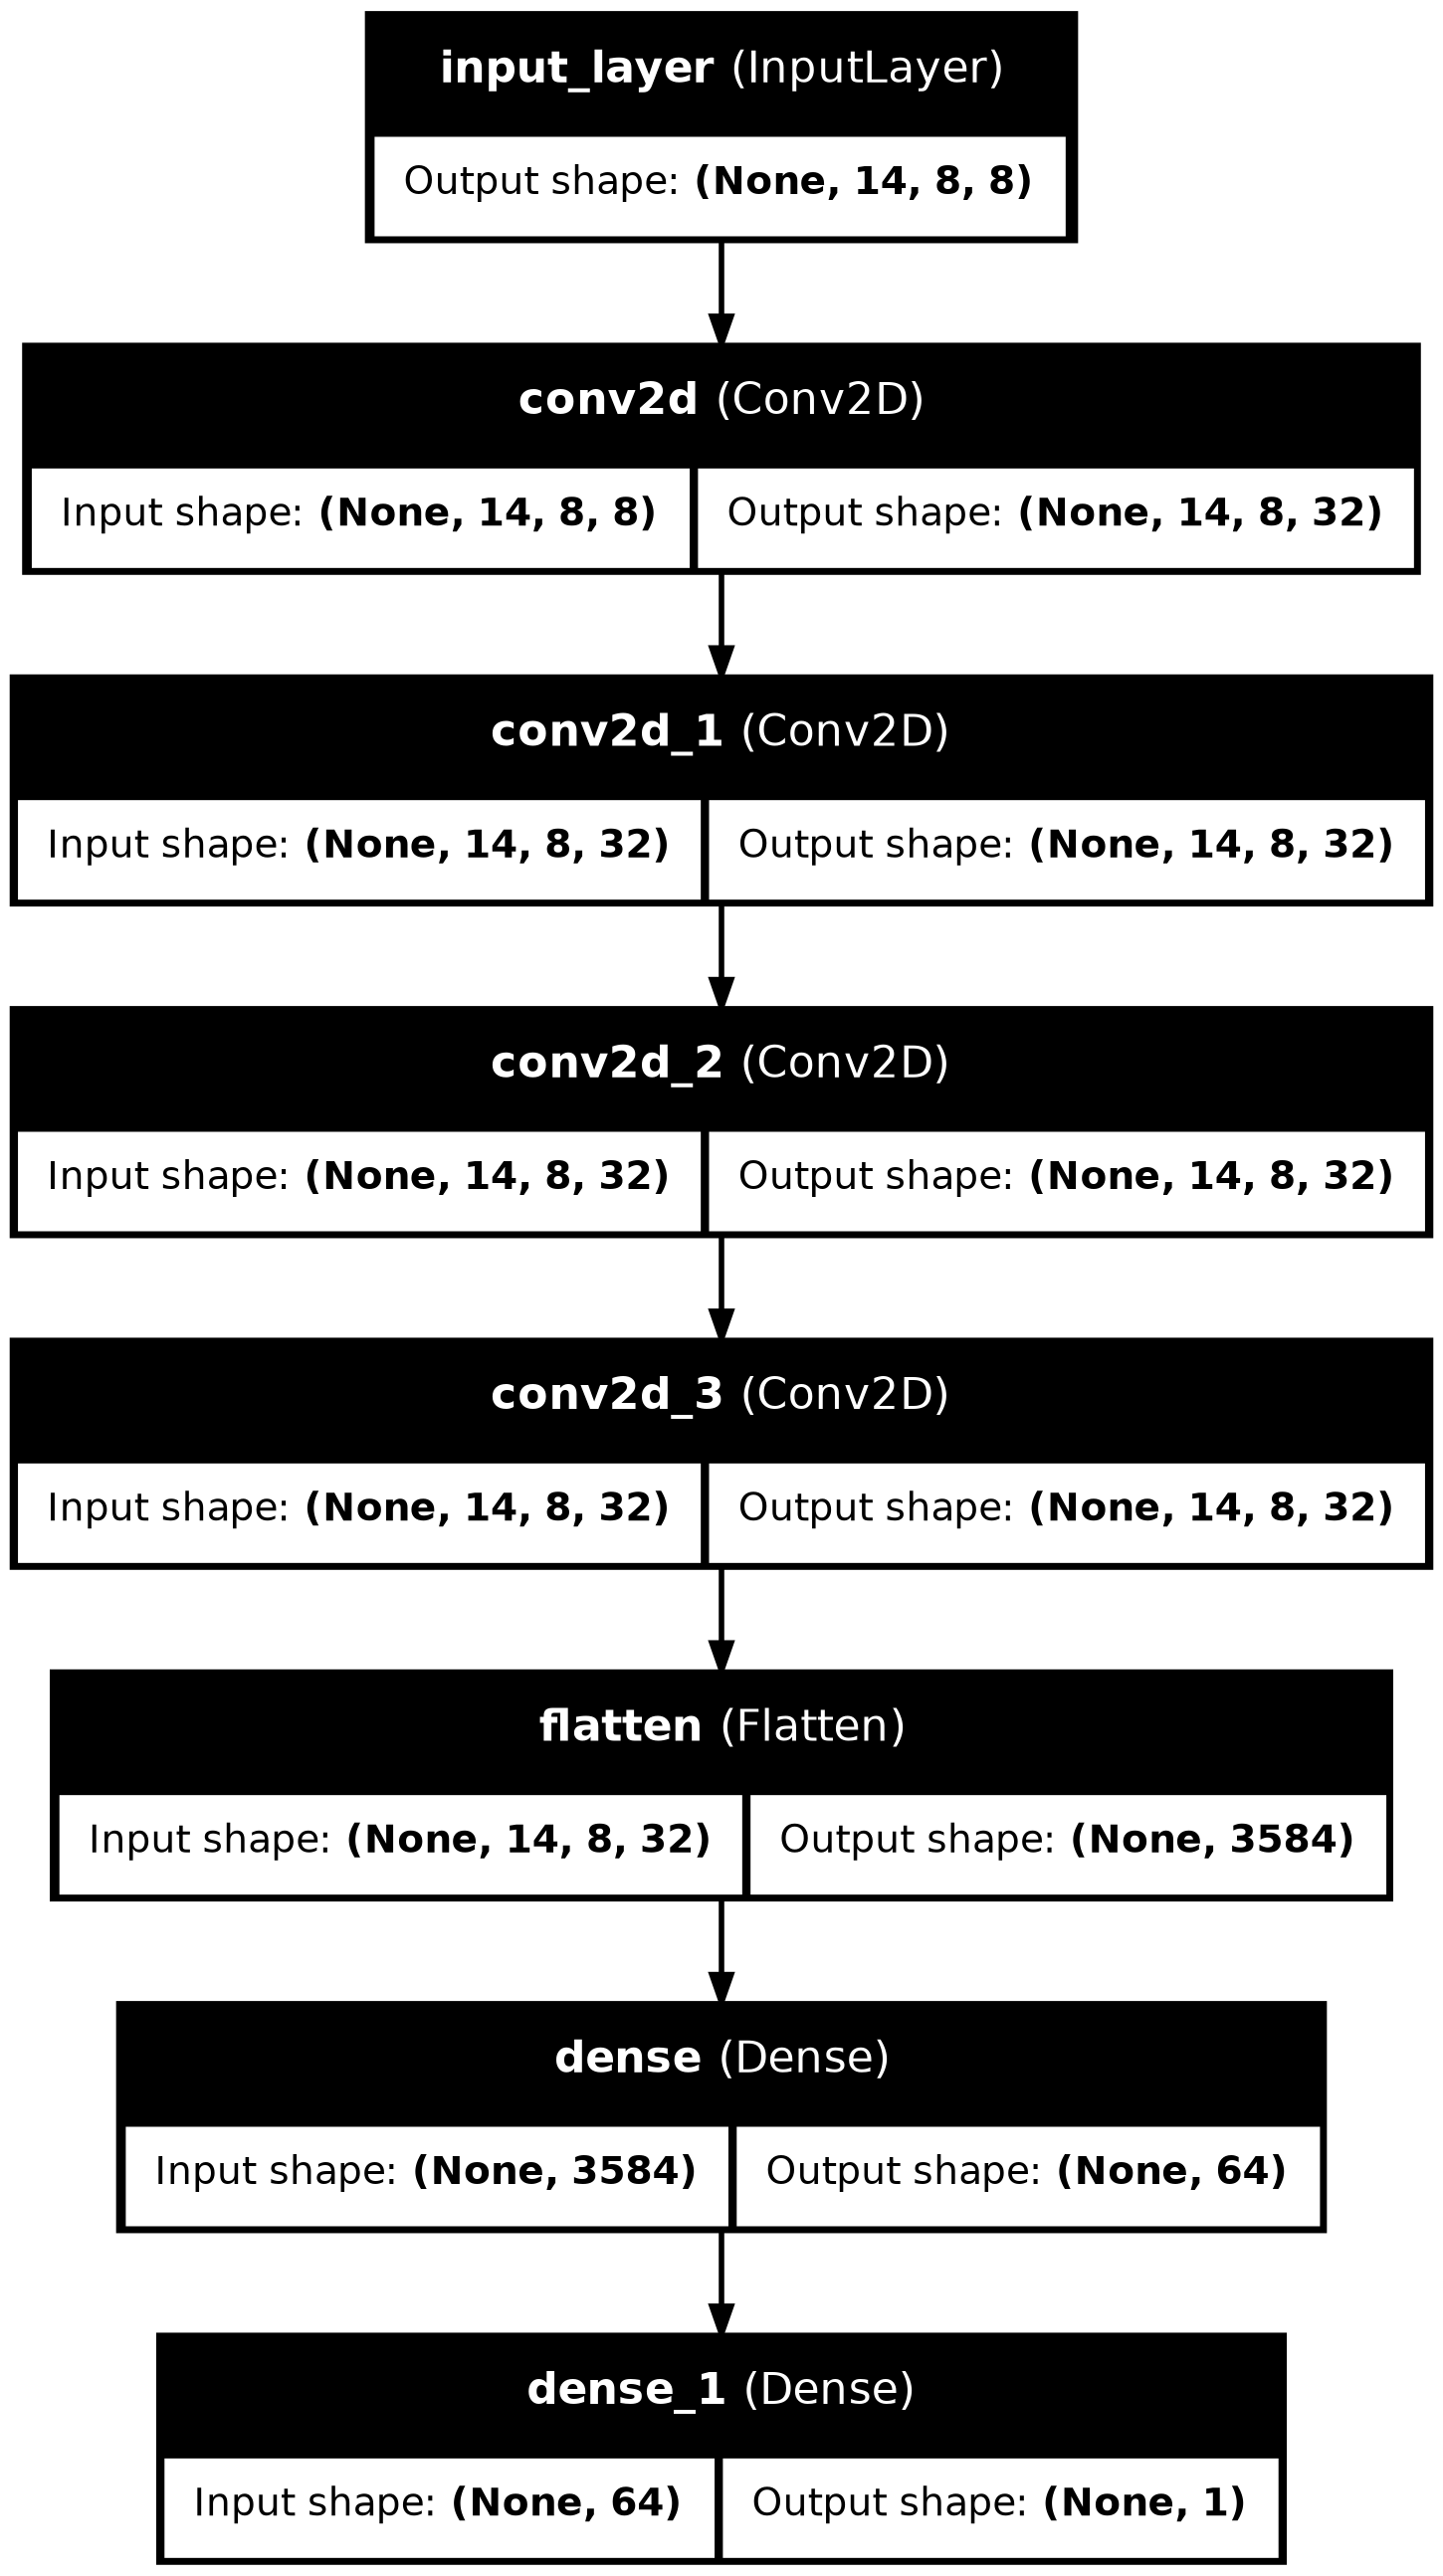

In [11]:
model = build_model(32, 4)
utils.plot_model(model, to_file = '../img/model_plot.png',
                 show_shapes = True, show_layer_names = True)

In [12]:
def build_model_residual(conv_size, conv_depth):
    board3d = layers.Input(shape = (14, 8, 8))
    
    x = layers.Conv2D(filters = conv_size, kernel_size = 3,
                      padding = 'same', activation = 'relu')(board3d)
    for _ in range(conv_depth):
        previous = x
        x = layers.Conv2D(filters = conv_size, kernel_size = 3,
                          padding = 'same', activation = 'relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters = conv_size, kernel_size = 3,
                          padding = 'same', activation = 'relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, previous])
        x = layers.Activation('relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation = 'sigmoid')(x)
    
    return models.Model(inputs = board3d, outputs = x)

In [15]:
import tensorflow.keras.callbacks as callbacks
from tqdm import tqdm

def get_dataset():
    num_samples = 10000 
    boards = []
    values = []
    for _ in tqdm(range(num_samples)):
        board = random_board(max_depth=200)
        value = stockfish(board, depth=1)
        if value is None:
            continue  # Skip if Stockfish evaluation is None
        # Convert Stockfish evaluation to a probability between 0 and 1
        prob = 1 / (1 + 10 ** (-value / 400))
        boards.append(split_dims(board))
        values.append(prob)
    b = np.array(boards)
    v = np.array(values)
    return b, v

x_train, y_train = get_dataset()
print(x_train.shape, y_train.shape)

100%|██████████| 1000/1000 [03:44<00:00,  4.46it/s]

(937, 14, 8, 8) (937,)


In [17]:
model_path = '../models/model_01_15.h5'
try:
    model = models.load_model(model_path)
    print("Model loaded successfully.")
except (OSError, IOError):
    print("Saved model not found. Using a new model.")

model.compile(optimizer = optimizers.Adam(5e-4), loss = 'mean_squared_error')
model.summary()
model.fit(x_train, y_train, 
          batch_size = 2048, 
          verbose = 1,
          epochs = 100, 
          validation_split = 0.1,
          callbacks = [callbacks.ReduceLROnPlateau(monitor = 'loss', patience = 10),
                       callbacks.EarlyStopping(monitor = 'loss', patience = 15, min_delta = 1e-4)])

model.save(model_path)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14, 8, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 8, 32)      │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 8, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 8, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 8, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3584)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       229,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,585 (1014.00 KB)

 Trainable params: 259,585 (1014.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0084 - val_loss: 0.3862 - learning_rate: 5.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 0.3576 - val_loss: 0.1677 - learning_rate: 5.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 0.0968 - val_loss: 0.1934 - learning_rate: 5.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.1438 - val_loss: 0.2053 - learning_rate: 5.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.1583 - val_loss: 0.1138 - learning_rate: 5.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0450 - val_loss: 0.1122 - learning_rate: 5.0000e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 0.0327 - val_loss: 0.1669 - learning_rate: 5.0000e-04
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0925 - val_loss: 0.1606 - learning_rate: 5.0000e-04
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.0856 - val_loss: 0.1128 - learning_rat

In [18]:
def minmax_eval(board):
    board3d = split_dims(board)
    board3d = np.expand_dims(board3d, axis = 0)
    return model.predict(board3d)[0][0]

def minimax(board, depth, alpha, beta, maximizing_player):
    if depth == 0 or board.is_game_over():
        return minmax_eval(board)
    if maximizing_player:
        max_eval = -np.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, False)
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return max_eval
    else:
        min_eval = np.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, True)
            board.pop()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return min_eval
    
def get_ai_move(board, depth = 3):
    best_move = None
    max_eval = -np.inf
    for move in board.legal_moves:
        board.push(move)
        eval = minimax(board, depth - 1, -np.inf, np.inf, False)
        board.pop()
        if eval > max_eval:
            max_eval = eval
            best_move = move
    return best_move

In [20]:
board = chess.Board()

with chess.engine.SimpleEngine.popen_uci("../stockfish/stockfish-ubuntu-x86-64-avx2") as engine:
    while True:
        move = get_ai_move(board, 1)
        board.push(move)
        print(f'\n{board}')
        if board.is_game_over():
            break
        
        move = engine.analyse(board, chess.engine.Limit(time = 1))['pv'][0]
        board.push(move)
        print(f'\n{board}')
        if board.is_game_over():
            break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R

r n b q k b n r
p p . p p p p p
. . . . . . . .
. . p . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P 